# Setup

In [1]:
from src.data.make_dataset import DataCreator
from src.features.preprocess import create_dataframe, DataPreprocessor, noising 
from src.models.model_setup import gmmhmm, IwrGaussianHMMModel
from src.models.model_selection import Noiser, GridSearch

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import colorednoise as cn
import librosa
import IPython

In [3]:
np.random.seed(7)

# Data Preparation

We will create DataCreator instance to simulate our dataset with 2400 observations (200 in each class + 400 in test set). <br>

Note: In case of converting .mp3 to .wav files, which is done with generate_observation method, you may need ffmpeg added to your local PATH.

In [14]:
dc = DataCreator()

dc.generate_observations(200)

We can inspect the length of each audio file in seconds.

In [69]:
# sr = 22050
# dc.max_len / sr
# > 1.2384580498866213

1.2384580498866213

# Preprocessing

From created files we make data frames for train and test set. Furthermore, we create mapper which is dictionary mapping id labels to class names.

In [16]:
train_df, test_df, mapper = create_dataframe(how_many=200)

In [17]:
train_df.head()

,path,word,label
0,data\train\yes\yes_112.wav,yes,9.0
1,data\train\no\no_180.wav,no,3.0
2,data\train\down\down_179.wav,down,0.0
3,data\train\stop\stop_115.wav,stop,7.0
4,data\train\stop\stop_176.wav,stop,7.0


Then we create DataProcesor instances to preprocess data sets, specifically calculate mfcc coefficients for each time window. 

In [18]:
train_dp = DataPreprocessor(train_df)
X_train, y_train = train_dp.mfcc(12, S=0.045, R=0.05)

In [19]:
test_dp = DataPreprocessor(test_df)
X_test, y_test = test_dp.mfcc(12, S=0.045, R=0.05)

In [20]:
X_train.shape

(2000, 12, 89)

In [21]:
X_test.shape

(400, 12, 89)

# Modelling

Creating exemplary model instance and checking how does it perform.

In [22]:
model = IwrGaussianHMMModel(n_states=6, n_iter=20)

model.fit(X_train, y_train)

We obtain 95% on train set and 

In [23]:
model.score(X_train, y_train)

{'accuracy': 0.893,
 'recall': 0.893,
 'precision': 0.9434579439252336,
 'f1': 0.859658081149408}

In [24]:
model.score(X_test, y_test)

{'accuracy': 0.895,
 'recall': 0.895,
 'precision': 0.9452380952380952,
 'f1': 0.8616635397123201}

# Noising

In thesis we will check how Gaussian HMM models performs on data with noise. We introduce 5 types of noise used in simulations.

## White noise

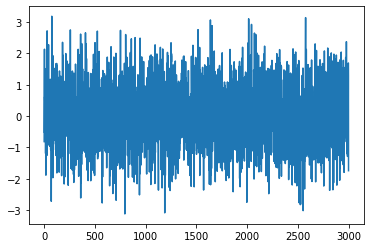

In [27]:
y = cn.powerlaw_psd_gaussian(0, 3000)
plt.plot(y)
plt.show()

## Pink noise
- gaussian noise for beta =1

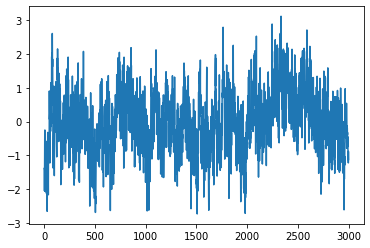

In [28]:
s = cn.powerlaw_psd_gaussian(1, 3000)
plt.plot(s)
plt.show()

## Szum browna
- gaussian noise for beta = 2

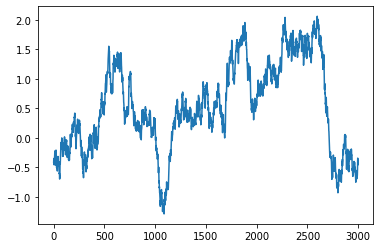

In [29]:
s = cn.powerlaw_psd_gaussian(2, 3000)
plt.plot(s)
plt.show()

## Niebieski szum
- gaussian noise for beta =-2

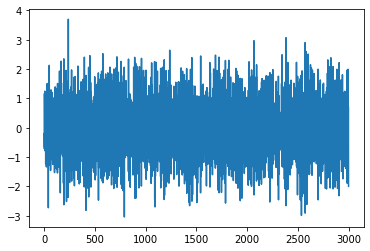

In [30]:
y = cn.powerlaw_psd_gaussian(-2, 3000)
plt.plot(y)
plt.show()

## Fioletowy szum
- gaussian noise for beta =-1

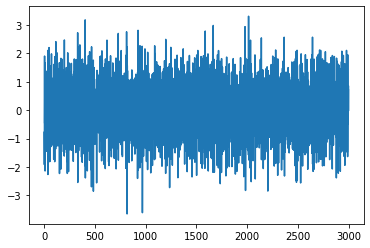

In [31]:
y = cn.powerlaw_psd_gaussian(-1, 3000)
plt.plot(y)
plt.show()

## Code

We will import random sample end check how it will be noised with our method.

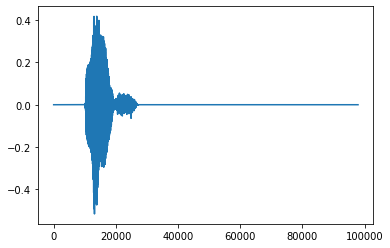

In [35]:
y, sr = librosa.load(r'data\train\yes\yes_93.wav')
plt.plot(y)
plt.show()

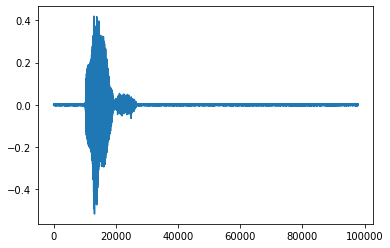

In [36]:
plt.plot(noising(y, 0, 0))
plt.show()

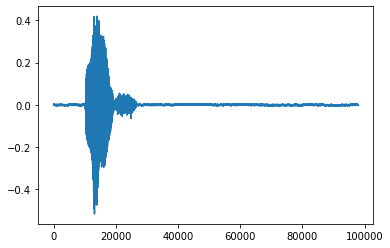

In [37]:
plt.plot(noising(y, 1, 0))
plt.show()

We can also check how does the difference between clean signal and noised sound.

In [40]:
IPython.display.Audio(data=y, rate=sr)

In [42]:
IPython.display.Audio(data=noising(y, 0, 0), rate=sr)

# Results

## Choosing model params

We will seek the most optimal model by searching the whole param net using k=5 fold stratified cross validation.

In [12]:
params = {'n_samples':[20, 100, 200],
          'n_mfcc':[13],
          'hop_wins':[0.01, 0.03, 0.05],
          'len_wins':[0.025, 0.04],
          'n_iters':[15, 30, 50],
          'n_hiddens':[4, 6, 12]}

gs = GridSearch(random_state=7)

In [29]:
results = gs.grid_search_model(params, k=5)

Iteration 1/162.
Iteration 5/162.
Iteration 10/162.
Iteration 15/162.
Iteration 20/162.
Iteration 25/162.
Iteration 30/162.
Iteration 35/162.
Iteration 40/162.
Iteration 45/162.
Iteration 50/162.
Iteration 55/162.
Iteration 60/162.
Iteration 65/162.
Iteration 70/162.
Iteration 75/162.
Iteration 80/162.
Iteration 85/162.
Iteration 90/162.
Iteration 95/162.
Iteration 100/162.
Iteration 105/162.
Iteration 110/162.
Iteration 115/162.
Iteration 120/162.
Iteration 125/162.
Iteration 130/162.
Iteration 135/162.
Iteration 140/162.
Iteration 145/162.
Iteration 150/162.
Iteration 155/162.
Iteration 160/162.


In [31]:
# results.to_csv(r'results\result_choose_model_params.csv')

## Adding randomness

We may also check how changing random parameters during data creation may affect the change in results.

In [ ]:
params = {
    'random_horizontal_shift': [0.1, 0.25, 0.4],
    'random_vertical_scaling': [0.5, 1, 10],
    'n_iter' : [15, 30, 50],
    'n_hiddens': [5, 6, 7]
}

gs = GridSearch(random_state=7)

results = gs.grid_search_randomness(params)

In [68]:
# results.to_csv(r'results\result_randomness.csv')

## Noising

Now after selecting proper model we can analyze how well can it predict noised test data

In [123]:
params = {
    'beta': [-2, -1, 0, 1, 2],
    'SNR': [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'n_iters' : [15],
    'n_hiddens': [6]
}

In [99]:
noise_gs = Noiser(random_state=7)

In [100]:
results = noise_gs.noise_hmm_results(params)

Iteration 1/60.
Iteration 5/60.
Iteration 10/60.
Iteration 15/60.
Iteration 20/60.
Iteration 25/60.
Iteration 30/60.
Iteration 35/60.
Iteration 40/60.
Iteration 45/60.
Iteration 50/60.
Iteration 55/60.
Iteration 60/60.


In [101]:
# results.to_csv(r'results\result_noise.csv')

## Noise to noise

We provide a method to stabilize results across bunch of different noises  with different signal-noise ratio. We search for model trained on specific noise genre data which is most often better than base model.

In [12]:
params = {
    'beta': [-2, -1, 0, 1, 2],
    'SNR': [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'chosen_snr': [5, 6, 7, 8, 9], 
    'n_iters' : [15],
    'n_hiddens': [6]
}

noise_gs = Noiser(random_state=7)
best, cost = noise_gs.best_noise_on_noise_grid_search(params)

Training base result...
Iteration 0/1500.
Iteration 60/1500. Evaluation time: 12 min 37.87 s
Iteration 120/1500. Evaluation time: 12 min 44.58 s
Iteration 180/1500. Evaluation time: 11 min 34.16 s
Iteration 240/1500. Evaluation time: 11 min 28.92 s
Iteration 300/1500. Evaluation time: 11 min 24.34 s
Iteration 360/1500. Evaluation time: 11 min 27.97 s
Iteration 420/1500. Evaluation time: 11 min 30.47 s
Iteration 480/1500. Evaluation time: 11 min 31.47 s
Iteration 540/1500. Evaluation time: 11 min 29.73 s
Iteration 600/1500. Evaluation time: 11 min 27.12 s
Iteration 660/1500. Evaluation time: 11 min 27.20 s
Iteration 720/1500. Evaluation time: 11 min 47.52 s
Iteration 780/1500. Evaluation time: 11 min 40.21 s
Iteration 840/1500. Evaluation time: 12 min 1.23 s
Iteration 900/1500. Evaluation time: 11 min 23.76 s
Iteration 960/1500. Evaluation time: 11 min 38.72 s
Iteration 1020/1500. Evaluation time: 11 min 58.57 s
Iteration 1080/1500. Evaluation time: 11 min 31.12 s
Iteration 1140/1500. E

We may observe how many times after applying our method the results are better than base model. As we can see, for beta=-2 and snr=9, accuracy most often is better than base model.

In [13]:
cost

beta_-2_snr_5    36
beta_-2_snr_6    36
beta_-2_snr_7    38
beta_-2_snr_8    39
beta_-2_snr_9    46
beta_-1_snr_5    36
beta_-1_snr_6    36
beta_-1_snr_7    37
beta_-1_snr_8    43
beta_-1_snr_9    38
beta_0_snr_5     39
beta_0_snr_6     27
beta_0_snr_7     38
beta_0_snr_8     38
beta_0_snr_9     37
beta_1_snr_5     20
beta_1_snr_6     30
beta_1_snr_7     26
beta_1_snr_8     29
beta_1_snr_9     30
beta_2_snr_5     18
beta_2_snr_6     19
beta_2_snr_7     20
beta_2_snr_8     26
beta_2_snr_9     20
dtype: int64

In [14]:
best

beta_-2_snr_9    46
dtype: int64

In [15]:
# cost.to_csv(r'results\cost_search_noise_on_noise.csv')

We performed simulations and selected best results via them. The next stage is visualization and inference from our solutions. Everything is conducted in visualization.ipynb file.